## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [52]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [53]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

In [54]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [55]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [56]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [57]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

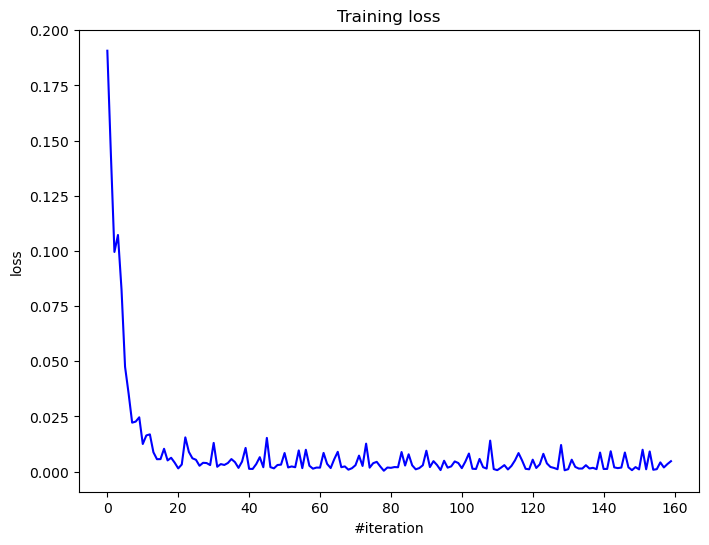

Current loss: 0.004739


In [58]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [59]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

File ‘mnist.py’ already there; not retrieving.



In [60]:
import sys
import os
import time

import numpy as np

__doc__="""taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""

def load_dataset(flatten=False):
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='https://storage.googleapis.com/cvdf-datasets/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return (data / np.float32(256)).squeeze()

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([-1, 28**2])
        X_val = X_val.reshape([-1, 28**2])
        X_test = X_test.reshape([-1, 28**2])


    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [61]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

One-hot encode the labels first.

In [62]:
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_one_hot = one_hot_encode(y_train)
y_val_one_hot = one_hot_encode(y_val)
y_test_one_hot = one_hot_encode(y_test)

print("Original y_train shape:", y_train.shape)
print("One-hot encoded y_train shape:", y_train_one_hot.shape)

Original y_train shape: (50000,)
One-hot encoded y_train shape: (50000, 10)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [63]:
# Your code goes here. ################################################

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [64]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [65]:
# Your code goes here. ################################################
# Flatten the input data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define a function to create and train a model
def train_model(model, criterion, optimizer_config, optimizer_func, X_train, y_train, X_val, y_val, n_epochs=10, batch_size=128):
    optimizer_state = {}
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(n_epochs):
        # Training
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            model.zeroGradParameters()
            
            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            epoch_loss += loss
            batch_count += 1
            
            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Update weights
            optimizer_func(model.getParameters(), 
                         model.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
        
        train_loss = epoch_loss / batch_count
        train_loss_history.append(train_loss)
        
        # Validation
        model.evaluate()
        val_predictions = model.forward(X_val)
        val_loss = criterion.forward(val_predictions, y_val)
        val_loss_history.append(val_loss)
        
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_loss_history, val_loss_history

# Define a function to calculate accuracy
def calculate_accuracy(model, X, y):
    model.evaluate()
    predictions = model.forward(X)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y, axis=1)
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy

# 1. Compare different activation functions
input_size = 28 * 28
hidden_size = 100
output_size = 10

# Create models with different activation functions
def create_model(activation_class, *args):
    model = Sequential()
    model.add(Linear(input_size, hidden_size))
    model.add(activation_class(*args))
    model.add(Linear(hidden_size, output_size))
    model.add(LogSoftMax())
    return model

# Initialize models
relu_model = create_model(ReLU)
elu_model = create_model(ELU, 1.0)
leaky_relu_model = create_model(LeakyReLU, 0.01)
softplus_model = create_model(SoftPlus)

# Define criterion and optimizer config
criterion = ClassNLLCriterion()
optimizer_config = {'learning_rate': 0.01, 'momentum': 0.9}

# Train models
print("Training ReLU model...")
relu_train_loss, relu_val_loss = train_model(
    relu_model, criterion, optimizer_config, sgd_momentum, 
    X_train_flat, y_train_one_hot, X_val_flat, y_val_one_hot, n_epochs=5
)

print("\nTraining ELU model...")
elu_train_loss, elu_val_loss = train_model(
    elu_model, criterion, optimizer_config, sgd_momentum, 
    X_train_flat, y_train_one_hot, X_val_flat, y_val_one_hot, n_epochs=5
)

print("\nTraining LeakyReLU model...")
leaky_relu_train_loss, leaky_relu_val_loss = train_model(
    leaky_relu_model, criterion, optimizer_config, sgd_momentum, 
    X_train_flat, y_train_one_hot, X_val_flat, y_val_one_hot, n_epochs=5
)

print("\nTraining SoftPlus model...")
softplus_train_loss, softplus_val_loss = train_model(
    softplus_model, criterion, optimizer_config, sgd_momentum, 
    X_train_flat, y_train_one_hot, X_val_flat, y_val_one_hot, n_epochs=5
)

# 2. Try BatchNormalization
def create_model_with_bn(activation_class, *args):
    model = Sequential()
    model.add(Linear(input_size, hidden_size))
    model.add(BatchNormalization(0.9))
    model.add(ChannelwiseScaling(hidden_size))
    model.add(activation_class(*args))
    model.add(Linear(hidden_size, output_size))
    model.add(LogSoftMax())
    return model

# Initialize model with BatchNormalization
relu_bn_model = create_model_with_bn(ReLU)

print("\nTraining ReLU model with BatchNormalization...")
relu_bn_train_loss, relu_bn_val_loss = train_model(
    relu_bn_model, criterion, optimizer_config, sgd_momentum, 
    X_train_flat, y_train_one_hot, X_val_flat, y_val_one_hot, n_epochs=5
)

# 3. Compare SGD with Adam
# Create a new model for Adam
relu_adam_model = create_model(ReLU)

# Adam optimizer config
adam_config = {'learning_rate': 0.001, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}

print("\nTraining ReLU model with Adam optimizer...")
relu_adam_train_loss, relu_adam_val_loss = train_model(
    relu_adam_model, criterion, adam_config, adam_optimizer, 
    X_train_flat, y_train_one_hot, X_val_flat, y_val_one_hot, n_epochs=5
)

# Plot the results
plt.figure(figsize=(12, 8))

# Plot validation losses for different activation functions
plt.subplot(2, 1, 1)
plt.semilogy(relu_val_loss, label='ReLU')
plt.semilogy(elu_val_loss, label='ELU')
plt.semilogy(leaky_relu_val_loss, label='LeakyReLU')
plt.semilogy(softplus_val_loss, label='SoftPlus')
plt.semilogy(relu_bn_val_loss, label='ReLU with BatchNorm')
plt.title('Validation Loss Comparison (Activation Functions & BatchNorm)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)

# Plot validation losses for SGD vs Adam
plt.subplot(2, 1, 2)
plt.semilogy(relu_val_loss, label='ReLU with SGD')
plt.semilogy(relu_adam_val_loss, label='ReLU with Adam')
plt.title('Validation Loss Comparison (SGD vs Adam)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate and print accuracies
print("\nAccuracies on validation set:")
print(f"ReLU: {calculate_accuracy(relu_model, X_val_flat, y_val_one_hot):.4f}")
print(f"ELU: {calculate_accuracy(elu_model, X_val_flat, y_val_one_hot):.4f}")
print(f"LeakyReLU: {calculate_accuracy(leaky_relu_model, X_val_flat, y_val_one_hot):.4f}")
print(f"SoftPlus: {calculate_accuracy(softplus_model, X_val_flat, y_val_one_hot):.4f}")
print(f"ReLU with BatchNorm: {calculate_accuracy(relu_bn_model, X_val_flat, y_val_one_hot):.4f}")
print(f"ReLU with Adam: {calculate_accuracy(relu_adam_model, X_val_flat, y_val_one_hot):.4f}")

Training ReLU model...
Epoch 1/5, Train Loss: 0.6878, Val Loss: 0.3166
Epoch 2/5, Train Loss: 0.3150, Val Loss: 0.2613
Epoch 3/5, Train Loss: 0.2653, Val Loss: 0.2280


KeyboardInterrupt: 

Print here your accuracy on test set. It should be around 90%.

In [ ]:
# Your code goes here. ################################################
# Define a function for learning rate decay
def learning_rate_decay(initial_lr, epoch, decay_rate=0.1, decay_steps=3):
    return initial_lr * (decay_rate ** (epoch // decay_steps))

# Define a function to train with learning rate decay
def train_model_with_lr_decay(model, criterion, optimizer_func, X_train, y_train, X_val, y_val, 
                             initial_lr=0.01, momentum=0.9, n_epochs=15, batch_size=128):
    optimizer_state = {}
    train_loss_history = []
    val_loss_history = []
    
    for epoch in range(n_epochs):
        # Update learning rate
        current_lr = learning_rate_decay(initial_lr, epoch)
        optimizer_config = {'learning_rate': current_lr, 'momentum': momentum}
        
        # Training
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            model.zeroGradParameters()
            
            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            epoch_loss += loss
            batch_count += 1
            
            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Update weights
            optimizer_func(model.getParameters(), 
                         model.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
        
        train_loss = epoch_loss / batch_count
        train_loss_history.append(train_loss)
        
        # Validation
        model.evaluate()
        val_predictions = model.forward(X_val)
        val_loss = criterion.forward(val_predictions, y_val)
        val_loss_history.append(val_loss)
        
        print(f'Epoch {epoch+1}/{n_epochs}, LR: {current_lr:.6f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_loss_history, val_loss_history

# Build a more advanced model
def create_advanced_model():
    model = Sequential()
    
    # First layer
    model.add(Linear(input_size, 256))
    model.add(BatchNormalization(0.9))
    model.add(ChannelwiseScaling(256))
    model.add(LeakyReLU(0.01))
    model.add(Dropout(0.2))
    
    # Second layer
    model.add(Linear(256, 128))
    model.add(BatchNormalization(0.9))
    model.add(ChannelwiseScaling(128))
    model.add(LeakyReLU(0.01))
    model.add(Dropout(0.3))
    
    # Output layer
    model.add(Linear(128, output_size))
    model.add(LogSoftMax())
    
    return model

# Create and train the advanced model
advanced_model = create_advanced_model()
criterion = ClassNLLCriterion()

print("Training advanced model...")
advanced_train_loss, advanced_val_loss = train_model_with_lr_decay(
    advanced_model, criterion, sgd_momentum, 
    X_train_flat, y_train_one_hot, X_val_flat, y_val_one_hot,
    initial_lr=0.05, momentum=0.9, n_epochs=15
)

Training advanced model...
Epoch 1/15, LR: 0.050000, Train Loss: 2.7226, Val Loss: 3.8539
Epoch 2/15, LR: 0.050000, Train Loss: 37.0466, Val Loss: 36.7422
Epoch 3/15, LR: 0.050000, Train Loss: 458.2231, Val Loss: 542.3616
Epoch 4/15, LR: 0.005000, Train Loss: 1010.5544, Val Loss: 344.1253


KeyboardInterrupt: 

### Comparing with PyTorch implementation
The last (and maybe the easiest) step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

__Good Luck!__

In [ ]:
# Your beautiful code here.